In [1]:
# import libraries
import numpy as np
import sys
import psi4
from helper_PFCI import PFHamiltonianGenerator
np.set_printoptions(threshold=sys.maxsize)
import scipy
from scipy.optimize import curve_fit
from scipy import interpolate
from matplotlib import pyplot as plt
from scipy import constants
from numpy.polynomial import Polynomial
import pandas as pd

/var/folders/ss/883k4s4x7qj7sr5ypdpszg9n7510f8/T/ipykernel_18753/4003142107.py:13: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [6]:
array_data = "/Users/ptolley1/Documents/Github/SCQED-PCQED/array_data"
cavity_E_array_0_00_T = np.load(array_data + "/HF/fci_cavity_arrays_HF_6311G0.npy").T
cavity_E_array_0_001_T = np.load(array_data + "/HF/fci_cavity_arrays_HF_6311G0_001.npy").T
cavity_E_array_0_005_T = np.load(array_data + "/HF/fci_cavity_arrays_HF_6311G0_005.npy").T
cavity_E_array_0_01_T = np.load(array_data + "/HF/fci_cavity_arrays_HF_6311G0_01.npy").T
cavity_E_array_0_02_T = np.load(array_data + "/HF/fci_cavity_arrays_HF_6311G0_02.npy").T
cavity_E_array_0_03_T = np.load(array_data + "/HF/fci_cavity_arrays_HF_6311G0_03.npy").T
cavity_E_array_0_04_T = np.load(array_data + "/HF/fci_cavity_arrays_HF_6311G0_04.npy").T
cavity_E_array_0_05_T = np.load(array_data + "/HF/fci_cavity_arrays_HF_6311G0_05.npy").T
dipoles_0 = np.load(array_data + "/HF/dipoles_HF0.npy")
dipoles_001 = np.load(array_data + "/HF/dipoles_HF0_001.npy")
dipoles_005 = np.load(array_data + "/HF/dipoles_HF0_005.npy")
dipoles_01 = np.load(array_data + "/HF/dipoles_HF0_01.npy")
dipoles_02 = np.load(array_data + "/HF/dipoles_HF0_02.npy")
dipoles_03 = np.load(array_data + "/HF/dipoles_HF0_03.npy")
dipoles_04 = np.load(array_data + "/HF/dipoles_HF0_04.npy")
dipoles_05 = np.load(array_data + "/HF/dipoles_HF0_05.npy")
r_data = np.load(array_data + "/HF/fci_r_array_HF.npy")
N_R = r_data.shape[0]
r_data = np.linspace(0.5,2.5,N_R)

## Calculation of k
Fit ground state PES of H2 to a quintic polynomial

In [7]:
import warnings
def declutter_E_array(E_array, dipoles,  r_data, discontinuity_threshold_std = 1, energy_diff_threshold_std = 2,  num_to_declutter = 2):


    #dipole array orderd as [numroots][numroots][dipole vector][bondlength]
    E_array = np.copy(E_array)
    new_E_array = np.zeros_like(E_array)


    d_reshaped= np.zeros_like(E_array)

    def vector_magnitude(vector):
        return np.sqrt(vector[0]**2 + vector[1]**2 + vector[2]**2)


    for q in range(dipoles.shape[3]):
        for i in range(dipoles.shape[0]):
            for j in range(dipoles.shape[1]):
                if i == j:
                    d_reshaped[q][i] = vector_magnitude(dipoles[i,i,:,q])
  
    dipoles = np.copy(d_reshaped)
    new_dipoles = np.zeros_like(dipoles)




    #dipole discontinuities
    for i in range(0,num_to_declutter):
        previous_intersection = 0
        for z in range(0,50):
            for j in range(i+1, E_array.shape[1]):
                array1 = E_array[:, i]
                array2 = E_array[:, j]

                dipole_array1 = dipoles[:, i] [previous_intersection:]
                dipole_array2 = dipoles[:, j] [previous_intersection:]


                #Only want array from previous intersection so it doesnt get recrossed
                array1_from_previous_intersection = array1[previous_intersection:]
                array2_from_previous_intersection = array2[previous_intersection:]
                #trying to determine how close two energy surfaces get, if they get very close this some evidence that they crossover
                diff_array1 = np.diff(array1_from_previous_intersection)
                diff_array2 = np.diff(array2_from_previous_intersection)
                std1 = np.std(np.abs(diff_array1))
                mean1 = np.mean(np.abs(diff_array1))
                std2 = np.std(np.abs(diff_array2))
                mean2 = np.mean(np.abs(diff_array2))
                energy_diff_threshold = ((mean1 + mean2)/2) + (((std1+std2)/2) * energy_diff_threshold_std)
                #find closest points
                #print(np.abs(np.abs(array1[previous_intersection:]) - np.abs(array2[previous_intersection:])))
                closest_indices =np.where(np.abs(np.abs(array1[previous_intersection:]) - np.abs(array2[previous_intersection:])) < energy_diff_threshold)
                try:

                    #if energies are close and there are two matcjhing discontinuities in dipole arrary 
                    dipoles_diff_1 = np.diff(dipole_array1)
                    dipoles_diff_2 = np.diff(dipole_array2)

                    mean_1 = np.mean(dipoles_diff_1)
                    mean_2 = np.mean(dipoles_diff_2)

                    std_1 = np.std(dipoles_diff_1)
                    std_2 = np.std(dipoles_diff_2)
                    discontinuity_threshold_pos =  mean_1 + (std_1*discontinuity_threshold_std)
                    discontinuity_threshold_neg =  mean_1 - (std_1*discontinuity_threshold_std)
                    idx_1 = np.sort(np.concatenate([ np.where( dipoles_diff_1 >  discontinuity_threshold_pos )[0]+1 ,  np.where( dipoles_diff_1 <  discontinuity_threshold_neg )[0]+1 ]))

                    discontinuity_threshold_pos =  mean_2 + (std_2*discontinuity_threshold_std)
                    discontinuity_threshold_neg =  mean_2 - (std_2*discontinuity_threshold_std)
                    idx_2 = np.sort(np.concatenate([ np.where( dipoles_diff_2 >  discontinuity_threshold_pos )[0]+1 ,  np.where( dipoles_diff_2 <  discontinuity_threshold_neg )[0]+1 ]))



                    if (len(idx_1)!= 0 and len(idx_2) != 0 ):
                        mask_idx1_idx2 = np.isin(idx_1, idx_2)
                        indices_idx1_in_idx2 = np.where(mask_idx1_idx2)[0]
                        indices_idx1_in_idx2 = idx_1[indices_idx1_in_idx2]

                        
                        if(len(indices_idx1_in_idx2) != 0 ):
                            mask_discontinuties_energydiff = np.isin(indices_idx1_in_idx2, closest_indices)
                            indices_discontinuties_in_energydiff = np.where(mask_discontinuties_energydiff)[0]

                            if len(indices_discontinuties_in_energydiff) != 0 :

                                idx = indices_idx1_in_idx2[indices_discontinuties_in_energydiff[0]]+ previous_intersection
                                #print(idx)
                                array1_copy = np.array(array1, copy=True)
                                array1 = np.concatenate([array1[:idx],  array2[idx:]])
                                array2 =np.concatenate([array2[:idx] , array1_copy[idx:]])


                                dipole_array1 = dipoles[:, i] 
                                dipole_array2 = dipoles[:, j]


                                dipole_array1_copy = np.array(dipole_array1, copy=True)
                                dipole_array1 = np.concatenate([dipole_array1[:idx],  dipole_array2[idx:]])
                                dipole_array2 =np.concatenate([dipole_array2[:idx] , dipole_array1_copy[idx:]])

                                dipoles[:,i] = dipole_array1
                                dipoles[:,j] = dipole_array2
                                E_array[:,i] = array1
                                E_array[:,j] = array2
                                previous_intersection = idx+1
                except():
                    print("uh oh")
        new_E_array[:,i ] = E_array[:,i]
        new_dipoles[:,i ] = dipoles[:, i]

    E_array = np.copy(new_E_array)
    new_E_array = np.zeros_like(E_array)


    for i in range(0,num_to_declutter):
        previous_intersection = 0
        for z in range(0,50):
            for j in range(i+1, E_array.shape[1]):
                array1 = E_array[:, i]
                array2 = E_array[:, j]
                #Only want array from previous intersection so it doesnt get recrossed
                array1_from_previous_intersection = array1[previous_intersection:]
                array2_from_previous_intersection = array2[previous_intersection:]
                #trying to determine how close two energy surfaces get, if they get very close this some evidence that they crossover
                diff_array1 = np.diff(array1_from_previous_intersection)
                diff_array2 = np.diff(array2_from_previous_intersection)
                std1 = np.std(np.abs(diff_array1))
                mean1 = np.mean(np.abs(diff_array1))
                std2 = np.std(np.abs(diff_array2))
                mean2 = np.mean(np.abs(diff_array2))
                energy_diff_threshold = ((mean1 + mean2)/2) + (((std1+std2)/2) * energy_diff_threshold_std)
                #find closest points
                #print(np.abs(np.abs(array1[previous_intersection:]) - np.abs(array2[previous_intersection:])))
                closest_indices =np.where(np.abs(np.abs(array1[previous_intersection:]) - np.abs(array2[previous_intersection:])) < energy_diff_threshold)
                try:
                    #use discontinuties in second derivative, discontinutities defined using standard deviation
                    dy_1 = np.abs(np.gradient(np.gradient(array1_from_previous_intersection, r_data[previous_intersection:], edge_order = 1), r_data[previous_intersection:], edge_order = 1))
                    std = np.std(abs(np.diff(dy_1)))
                    mean = np.mean(abs(np.diff(dy_1)))
                    discontinuity_threshold =  mean + (std*discontinuity_threshold_std)
                    idx_1 = np.where(abs(np.diff(dy_1)) >  discontinuity_threshold)[0]+2
                    dy_2= np.abs(np.gradient(np.gradient(array2_from_previous_intersection, r_data[previous_intersection:], edge_order=1), r_data[previous_intersection:], edge_order=1))
                    std = np.std(abs(np.diff(dy_2)))
                    mean = np.mean(abs(np.diff(dy_2)))
                    discontinuity_threshold =  mean + (std*discontinuity_threshold_std)
                    idx_2 = np.where(abs(np.diff(dy_2)) > discontinuity_threshold)[0]+2
                    if (len(idx_1)!= 0 and len(idx_2) != 0 ):
                        mask_idx1_idx2 = np.isin(idx_1, idx_2)
                        indices_idx1_in_idx2 = np.where(mask_idx1_idx2)[0]
                        indices_idx1_in_idx2 = idx_1[indices_idx1_in_idx2]
                        # indices_idx1_in_idx2  = indices_idx1_in_idx2[ending_index:]
                        # starting_index=ending_index
                        # ending_index = starting_index
                        starting_index = 0
                        ending_index = 0
                        for elem_index in range(len(indices_idx1_in_idx2)-1):
                            #print("ayo: ", abs((indices_idx1_in_idx2[elem_index]) - (indices_idx1_in_idx2[elem_index+1])))
                            if abs((indices_idx1_in_idx2[elem_index]) - (indices_idx1_in_idx2[elem_index+1])) < 25 :
                                ending_index = ending_index+1
                            else:
                                break
                        indices_idx1_in_idx2 = indices_idx1_in_idx2[starting_index:ending_index]
                        if(len(indices_idx1_in_idx2) != 0 ):
                            mask_discontinuties_energydiff = np.isin(indices_idx1_in_idx2, closest_indices)
                            indices_discontinuties_in_energydiff = np.where(mask_discontinuties_energydiff)[0]
                            #print(indices_discontinuties_in_energydiff)
                            #print(indices_discontinuties_in_energydiff)
                            if len(indices_discontinuties_in_energydiff) != 0 :
                                for k in range(len(indices_discontinuties_in_energydiff) - 1):
                                    idx = indices_idx1_in_idx2[indices_discontinuties_in_energydiff[k]]+ previous_intersection
                                    #print(idx)
                                    array1_copy = np.array(array1, copy=True)
                                    array1 = np.concatenate([array1[:idx],  array2[idx:idx+1], array1[idx+1:]])
                                    array2 = np.concatenate([array2[:idx] , array1_copy[idx:idx+1], array2[idx+1:]])
                                    E_array[:,i] = array1
                                    E_array[:,j] = array2
                                idx = indices_idx1_in_idx2[indices_discontinuties_in_energydiff[-1]]+ previous_intersection
                                #print(idx)
                                array1_copy = np.array(array1, copy=True)
                                array1 = np.concatenate([array1[:idx],  array2[idx:]])
                                array2 =np.concatenate([array2[:idx] , array1_copy[idx:]])
                                #print(indices_idx1_in_idx2)
                                fitting_distance=10
                                if abs(indices_idx1_in_idx2[-1] - indices_idx1_in_idx2[0]) < fitting_distance:
                                    array1 = array1.tolist()
                                    array2 = array2.tolist()
                                    r_data_list = r_data.tolist()
                                    #fitting region
                                    end_discontinuity = indices_idx1_in_idx2[indices_discontinuties_in_energydiff[-1]]+ previous_intersection
                                    start_discontinuity = indices_idx1_in_idx2[indices_discontinuties_in_energydiff[0]]+ previous_intersection
                                    fit_E_data_end = min(end_discontinuity+fitting_distance, len(array1))
                                    fit_E_data_start= max(start_discontinuity-fitting_distance, 0)
                                    # print(fit_E_data_start)
                                    # print(fit_E_data_end)
                                    fitting_E_data = array1[fit_E_data_start: start_discontinuity] + array1[end_discontinuity: fit_E_data_end]
                                    fitting_r_data = r_data_list[fit_E_data_start: start_discontinuity] + r_data_list[end_discontinuity:fit_E_data_end]
                                    with warnings.catch_warnings():
                                        warnings.simplefilter("ignore")
                                        poly = np.poly1d(np.polyfit(fitting_r_data, fitting_E_data, 12))
                                    r_data_fitting_list =  r_data_list[fit_E_data_start:fit_E_data_end]
                                    polyvals = np.polyval(np.asarray(poly),r_data_fitting_list )
                                    array1 = array1[:fit_E_data_start] + polyvals.tolist() + array1[fit_E_data_end:]
                                    fitting_E_data = array2[fit_E_data_start: start_discontinuity] + array2[end_discontinuity: fit_E_data_end]
                                    fitting_r_data = r_data_list[fit_E_data_start: start_discontinuity] + r_data_list[end_discontinuity:fit_E_data_end]
                                    with warnings.catch_warnings():
                                        warnings.simplefilter("ignore")
                                        poly = np.poly1d(np.polyfit(fitting_r_data, fitting_E_data, 12))
                                    r_data_fitting_list =  r_data_list[fit_E_data_start:fit_E_data_end]
                                    polyvals = np.polyval(np.asarray(poly),r_data_fitting_list )
                                    array2 = array2[:fit_E_data_start] + polyvals.tolist() + array2[fit_E_data_end:]
                                E_array[:,i] = array1
                                E_array[:,j] = array2
                                previous_intersection = idx
                except():
                    print("uh oh")
        new_E_array[:,i ] = E_array[:,i]
    



    return new_E_array

In [8]:
for i in range(10):
    cavity_E_array_0_00  = declutter_E_array(cavity_E_array_0_00_T, dipoles_0, r_data, 3, 7,num_to_declutter=12)
    cavity_E_array_0_001  = declutter_E_array(cavity_E_array_0_001_T, dipoles_001, r_data, 3, 7,num_to_declutter=12)
    cavity_E_array_0_005  = declutter_E_array(cavity_E_array_0_005_T, dipoles_005, r_data, 3, 7,num_to_declutter=12)
    cavity_E_array_0_01  = declutter_E_array(cavity_E_array_0_01_T, dipoles_01, r_data, 3, 7,num_to_declutter=12)
    cavity_E_array_0_02  = declutter_E_array(cavity_E_array_0_02_T, dipoles_02, r_data, 3, 7,num_to_declutter=12)
    cavity_E_array_0_03  = declutter_E_array(cavity_E_array_0_03_T, dipoles_03, r_data, 3, 7,num_to_declutter=12)
    cavity_E_array_0_04  = declutter_E_array(cavity_E_array_0_04_T, dipoles_04, r_data, 3, 7,num_to_declutter=12)
    cavity_E_array_0_05  = declutter_E_array(cavity_E_array_0_05_T, dipoles_05, r_data, 3, 7,num_to_declutter=12)


/Users/ptolley1/anaconda3/envs/work/lib/python3.11/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/ptolley1/anaconda3/envs/work/lib/python3.11/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/Users/ptolley1/anaconda3/envs/work/lib/python3.11/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/ptolley1/anaconda3/envs/work/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/ptolley1/anaconda3/envs/work/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/ptolley1/anaconda3/envs/work

In [62]:
S0_array = cavity_E_array_0_00[:,0]
S1_array = cavity_E_array_0_00[:,6]


LP_arrays = np.array([cavity_E_array_0_00[:,1],
            cavity_E_array_0_001[:,1],
            cavity_E_array_0_005[:,1],
            cavity_E_array_0_01[:,1],
            cavity_E_array_0_02[:,1],
            cavity_E_array_0_03[:,1],
            cavity_E_array_0_04[:,1],
            cavity_E_array_0_05[:,1]
                      ]
              )

UP_arrays = np.array([cavity_E_array_0_00[:,6],
            cavity_E_array_0_001[:,6],
            cavity_E_array_0_005[:,7],
            cavity_E_array_0_01[:,6],
            cavity_E_array_0_02[:,6],
            cavity_E_array_0_03[:,6],
            cavity_E_array_0_04[:,6],
            cavity_E_array_0_05[:,6]
                      ]
              )

1.605527638190955
2.5
-0.5463489841038864


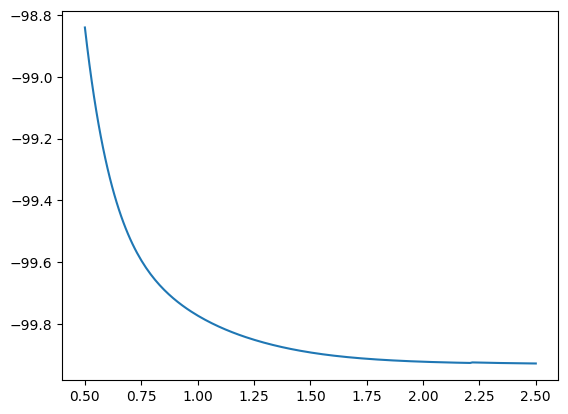

In [61]:
plt.plot(r_data, cavity_E_array_0_04[:,2])

print(r_data[110])
min_loc = np.argmin(cavity_E_array_0_00[:,5])
print(r_data[min_loc])
print(cavity_E_array_0_00[110,0] - cavity_E_array_0_00[110,8])

In [56]:
omega_test = np.abs(cavity_E_array_0_00[74,0] - cavity_E_array_0_00[74, 6])
print(omega_test)
print(r_data[74])

0.45060563391214714
1.2437185929648242


Min on S0 is 0.9321608040201005
Min on S1 is 1.9673366834170853
       14        13         12         11        10        9
0.303 x  - 6.58 x  + 65.41 x  - 394.3 x  + 1610 x  - 4710 x
              8             7             6             5             4
 + 1.018e+04 x - 1.653e+04 x + 2.028e+04 x - 1.877e+04 x + 1.296e+04 x
         3        2
 - 6519 x + 2289 x - 511.8 x - 43.77
914.2664987426288


<function matplotlib.pyplot.show(close=None, block=None)>

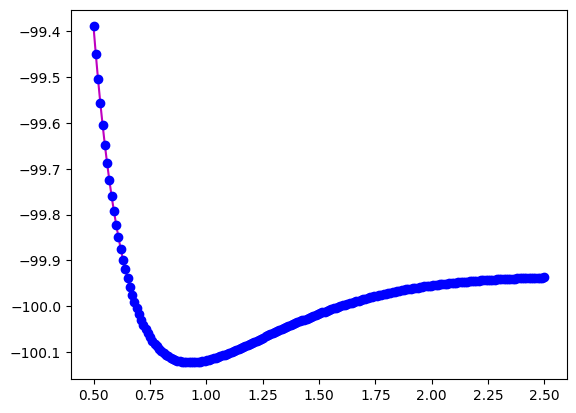

In [57]:

min_S0_loc = np.argmin(S0_array[:])
min_S1_loc = np.argmin(S1_array[:])

min_LP_array = np.zeros((1,8))
min_UP_array = np.zeros((1,8))

for i in range(8):
    min_LP_array[0,i] = np.argmin(LP_arrays[i])
    min_UP_array[0,i] = np.argmin(UP_arrays[i])



r_eq_ang = r_data[min_S0_loc]
print(f'Min on S0 is {r_data[min_S0_loc]}')
print(f'Min on S1 is {r_data[min_S1_loc]}')
#print(f'Min on LP is {r_data[min_LP_loc]}')
#print(f'Min on UP is {r_data[min_UP_loc]}')

# Fitting S0 PES to a quintic polynomial
au_to_SI = (4.35974 * 10 ** (-18)) * 10 ** 20
poly = np.poly1d(np.polyfit(r_data, S0_array, 14))
print(poly)

#Taking first and second derivative of S0 PES and evaluating at r_eq
first_derivative = poly.deriv()
second_derivative = first_derivative.deriv()
k_test_au = second_derivative(r_eq_ang)
k_test_SI = k_test_au * au_to_SI
print(k_test_SI)

#plotting S0 PES and quintic fit
plt.plot(r_data, poly(r_data), 'm-', label='fit')
plt.plot(r_data, S0_array[:], 'bo', label='cavity free |g>')
plt.show

## Calculation of $ \text{x}_0 $

$$ \frac{\hbar}{2}\sqrt{\frac{k}{\mu}} = \frac{k}{2}(x_0 - x_{eq})^2 + V_0 $$

Expanded, solved for $ x_o $, and found zeros using quadratic formula

In [58]:
mu_amu = 1.00784 * 1.00784 / (1.00784 + 1.00784)
mu_kg = mu_amu  * 10 ** (-3) / (6.022 * 10 ** 23) 
r_eq_SI = r_eq_ang * 10 ** (-10)
h_bar = constants.hbar
V_0_loc = np.argmin(S0_array)
V_0 = S0_array[V_0_loc] * 4.35974 * 10 ** (-18)
left = (h_bar / 2) * np.sqrt(k_test_SI / mu_kg)
a = 0.5 * k_test_SI 
b = -k_test_SI * r_eq_SI
c = 0.5 * k_test_SI * (r_eq_SI ** 2) - left
zeros_n = (-b - np.sqrt((b ** 2) - 4 * a * c)) / (2 * a)
zeros_p = (-b + np.sqrt((b ** 2) - 4 * a * c)) / (2 * a)
x0_angstrom = zeros_n * 10 ** 10
x0_au = x0_angstrom / psi4.constants.bohr2angstroms
print(x0_angstrom)
for i in range(8):
    print(r_data[[int(min_UP_array[0,i])]])

0.822357687212761
[1.96733668]
[1.96733668]
[1.00251256]
[1.2638191]
[1.2638191]
[1.2638191]
[1.25376884]
[1.25376884]


## Calculation of the Huang-Rhys Factor
Huang Rhys factor can be calculated by both

$$ S = 1/2(\Delta x / x_0)^2 \tag{Turner}$$

from the mode anharmonicity paper

and 

$$ S = \frac{m\omega_{vib} \Delta x^2}{2 \hbar} \tag{Hsu}$$

from the polaritonic Huang-Rhys factor paper

In [59]:
# Constants and Variables
delta_au = (r_data[min_S1_loc] - r_data[min_S0_loc]) / psi4.constants.bohr2angstroms

delta_LP_au = np.zeros((1,8))
delta_UP_au = np.zeros((1,8))

for i in range(8):
    delta_LP_au[0,i] = (r_data[int(min_LP_array[0,i])] - r_data[min_S0_loc]) / psi4.constants.bohr2angstroms
    delta_UP_au[0,i] = (r_data[int(min_UP_array[0,i])] - r_data[min_S0_loc]) / psi4.constants.bohr2angstroms


delta_m = (r_data[min_S1_loc] - r_data[min_S0_loc]) * 10 ** (-10)
delta_angstrom = (r_data[min_S1_loc] - r_data[min_S0_loc])
omega_vib = np.sqrt(k_test_SI / mu_kg)
h_bar = constants.hbar
x0_test = np.sqrt(h_bar * omega_vib / k_test_SI)
x0_test_au = (x0_test * 10 ** (10))  / psi4.constants.bohr2angstroms

# Turner
S_Turner = 0.5 * (delta_au / x0_test_au) ** 2

# Hsu
S_Hsu = mu_kg * omega_vib * delta_m ** 2 / (2 * h_bar)

#g and LP 

HR_LP_array = np.zeros((1,8))
HR_UP_array = np.zeros((1,8))

for i in range(8):
    HR_LP_array[0,i] = 0.5 * (delta_LP_au[0,i] / x0_test_au) ** 2
    HR_UP_array[0,i] = 0.5 * (delta_UP_au[0,i] / x0_test_au) ** 2

print('|g> and |e> HR Factor')
print(S_Turner)
print(S_Hsu)

print('LP and UP HR Factor')
print(HR_LP_array)
print(HR_UP_array)


df = pd.DataFrame(HR_LP_array.reshape(-1,1))
df.to_clipboard()

|g> and |e> HR Factor
44.43947876500823
44.43947876500823
LP and UP HR Factor
[[101.93978275 101.93978275 101.93978275 101.93978275 101.93978275
  101.93978275 101.93978275  92.99659422]]
[[44.43947877 44.43947877  0.20525351  4.56165448  4.56165448  4.56165448
   4.28937942  4.28937942]]


First plot the ground-state potential energy surfaces for $ \text{H2} $ inside and outisde the cavity.  The effect of the cavity will raise the energy slightly.

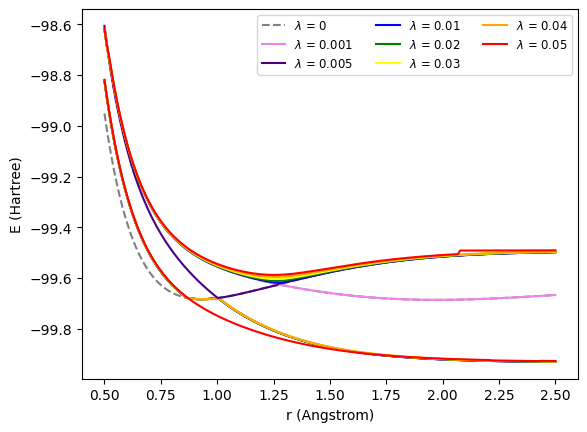

In [60]:
lambda_list = [0, 0.001, 0.005, 0.01, 0.02, 0.03, 0.04, 0.05]
fci_S0_omega = np.zeros((1, N_R))
for i in range(N_R):
    fci_S0_omega[0,i] = S0_array[i] + 0.4388785987545134
fci_S0_plusw = np.ndarray.flatten(fci_S0_omega)

color_list_1 = ['grey','violet','indigo','blue','green','yellow','orange','red']

plt.plot(r_data, fci_S0_plusw, linestyle='dashed', color='gray', label=f'$\lambda$ = 0')
plt.plot(r_data, S1_array, linestyle='--', color='gray')

for i in range(1,8):
    plt.plot(r_data, LP_arrays[i,:], f'{color_list_1[i]}', label=f'$\lambda$ = {lambda_list[i]}')
for k in range(1,8):
        plt.plot(r_data, UP_arrays[k,:], f'{color_list_1[k]}',)

plt.xlabel('r (Angstrom)')
plt.ylabel('E (Hartree)')


#plt.xlim(1.5, 2)
#plt.ylim(-7.76, -7.72)
plt.legend(loc = 'upper right', ncols = 3, fontsize = 'small')
plt.savefig('polariton_surfaces_LiH.png',dpi=500)
#plt.show()

In [ ]:
plt.plot(lambda_list, HR_UP_array[0,:], 'ro-', label='UP')
plt.plot(lambda_list, HR_LP_array[0,:], 'bo-', label='LP')
plt.legend()
plt.xlabel('Lambda')
plt.ylabel('S')
plt.savefig('H2_trends.png', dpi=1000)

In [ ]:
#pd.DataFrame(matrix).to_clipboard()

omega_test = np.abs(fci_S0[100] - fci_S1[100])
print(omega_test)
print(r_data[100])


In [ ]:
lambda_list = [0, 0.001, 0.005, 0.01, 0.02, 0.03, 0.04, 0.05]
fci_S0_omega = np.zeros((1, N_R))
for i in range(N_R):
    fci_S0_omega[0,i] = S0_array[i] + 0.12086
fci_S0_plusw = np.ndarray.flatten(fci_S0_omega)

color_list_1 = ['grey','violet','indigo','blue','green','yellow','orange','red']

plt.plot(r_data, fci_S0_plusw, linestyle='dashed', color='gray', label=f'$\lambda$ = 0')
plt.plot(r_data, S1_array, linestyle='--', color='gray')

for i in range(2,8):
    plt.plot(r_data, LP_arrays[i,:], f'{color_list_1[i]}', label=f'$\lambda$ = {lambda_list[i]}')
for k in range(2,8):
        plt.plot(r_data, UP_arrays[k,:], f'{color_list_1[k]}',)

plt.xlabel('r (Angstrom)')
plt.ylabel('E (Hartree)')


#plt.xlim(1.5, 2)
#plt.ylim(-7.76, -7.72)
#plt.legend(loc = 'upper right', ncols = 3, fontsize = 'small')
plt.axis('off')
plt.savefig('polariton_surfaces_LiH_No_Background.png', transparent=True, dpi=500)
#plt.show()